In [1]:
# Importing the required modules

In [2]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
import pickle
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Krishna']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
1434,1434,16.71,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,8.04,0.29,0.49,12.14,98.0,4662.0,490.0,36.95,0.34,0.63,6.23,1.77,15.20,0.505760,0.293100,1.147562,2.271589,-0.531790,Cotton
1435,1435,16.70,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,7.98,0.56,0.40,25.06,222.0,3669.0,558.0,38.58,0.98,0.55,3.70,1.06,11.12,0.757852,0.606363,2.409551,4.176944,-0.676215,Chilli
1436,1436,16.71,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,8.08,0.42,0.43,10.05,160.0,5107.0,1453.0,21.19,0.51,1.19,10.85,2.37,22.73,0.505760,0.293100,1.147562,2.271589,-0.531790,Vegetables
1437,1437,16.71,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,8.11,0.46,0.44,12.75,231.0,4812.0,1605.0,45.24,0.55,1.46,9.48,2.04,26.57,0.505760,0.293100,1.147562,2.271589,-0.531790,Vegetables
1438,1438,16.71,80.61,Krishna,G Konduru,Chevutur,Black,8.54,0.21,0.25,3.51,179.0,5183.0,1229.0,7.75,0.35,1.10,4.19,1.09,7.12,0.445642,0.253462,1.348015,1.743494,-0.465740,Cotton


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'NDVI', 'EVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,7.877293,0.881992,0.599737,21.031053,211.180451,5135.481203,1432.281955,105.633797,1.124436,1.755677,34.976241,7.602293,22.065714,0.250828
std,0.523106,1.572241,0.209099,14.304957,154.542433,1528.346835,609.168496,147.923428,1.016811,0.642349,28.610180,4.824919,12.788403,0.187601
min,6.070000,0.110000,0.160000,1.360000,77.000000,635.000000,165.000000,4.450000,0.140000,0.540000,1.400000,0.030000,5.500000,-0.421384
25%,7.620000,0.370000,0.430000,11.580000,133.000000,4369.750000,967.750000,23.857500,0.542500,1.300000,8.815000,2.347500,12.822500,0.092806
50%,7.980000,0.530000,0.610000,16.725000,171.000000,5295.000000,1435.500000,50.270000,0.900000,1.735000,31.950000,8.070000,19.520000,0.244825
75%,8.210000,0.807500,0.740000,27.590000,231.750000,6240.750000,1813.000000,118.027500,1.317500,2.102500,49.512500,11.770000,26.840000,0.395989
max,9.090000,20.300000,1.150000,105.720000,1572.000000,9718.000000,3730.000000,995.940000,8.840000,3.750000,166.850000,19.470000,88.540000,0.787234


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black', 'Red', 'BLACK'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace(['Black', 'BLACK'], 'Black Soil')
df['SoilType'] = df['SoilType'].replace('Red', 'Red Soil')
df.SoilType.unique()

array(['Black Soil', 'Red Soil'], dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 250, 'Red Soil': 16}

<BarContainer object of 2 artists>

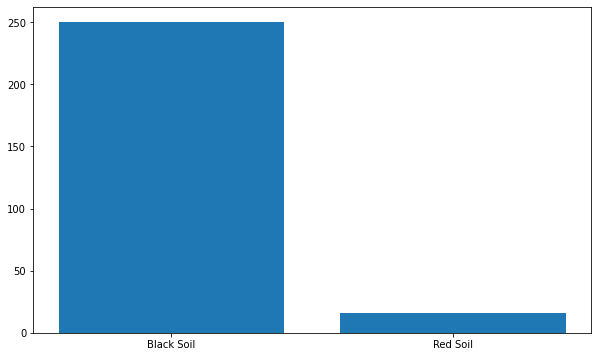

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Cotton', 'Chilli', 'Vegetables', 'cotton', 'chill', 'Paddy',
       'Vegetable', 'Black gram', 'Maize', 'PULSE', 'MAZI', 'maize',
       'Mazi'], dtype=object)

In [15]:
df['Crop'].value_counts()

PULSE         80
Cotton        63
Black gram    52
Maize         31
Mazi           9
Paddy          7
Vegetables     7
Chilli         6
cotton         5
MAZI           2
Vegetable      2
maize          1
chill          1
Name: Crop, dtype: int64

Pulse        80
Cotton       68
BlackGram    52
Maize        43
Name: Crop, dtype: int64


<BarContainer object of 4 artists>

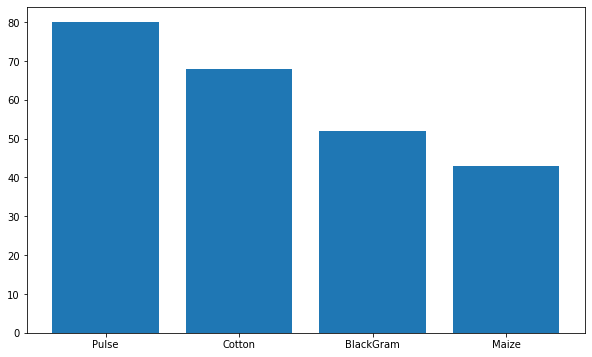

In [16]:
df['Crop'] = df['Crop'].replace('chill', 'Chilli')
df['Crop'] = df['Crop'].replace(['MAZI', 'maize', 'Mazi'], 'Maize')
df['Crop'] = df['Crop'].replace('cotton', 'Cotton')
df['Crop'] = df['Crop'].replace('Black gram', 'BlackGram')
df['Crop'] = df['Crop'].replace('PULSE', 'Pulse')
df = df[(df['Crop'] != 'Vegetable') & (df['Crop'] != 'Vegetables') & (df['Crop'] != 'Chilli') & (df['Crop'] != 'Paddy')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
pH,1.000000,-0.194779,-0.397251,-0.345533,0.059415,-0.247552,-0.340166,-0.291813,-0.210989,-0.290784,-0.765760,-0.622046,-0.555247,0.044923
EC,-0.194779,1.000000,0.224075,0.201661,0.273177,0.169868,0.226847,0.718952,0.072944,0.273555,0.027884,0.054795,0.087538,-0.138920
OC,-0.397251,0.224075,1.000000,0.510703,0.251032,0.325660,0.292660,0.482694,0.490665,0.393414,0.545253,0.632245,0.325593,-0.220293
P,-0.345533,0.201661,0.510703,1.000000,0.377933,0.005470,0.134836,0.294004,0.477350,0.353680,0.520016,0.341507,0.397529,-0.117177
K,0.059415,0.273177,0.251032,0.377933,1.000000,-0.070437,-0.003110,0.328830,0.323908,0.146462,0.002124,-0.036796,0.117925,0.017381
Ca,-0.247552,0.169868,0.325660,0.005470,-0.070437,1.000000,0.805193,0.135697,0.072989,0.361858,0.327271,0.637827,0.320087,-0.182320
Mg,-0.340166,0.226847,0.292660,0.134836,-0.003110,0.805193,1.000000,0.145356,0.077283,0.660054,0.426279,0.706528,0.448127,-0.126662
S,-0.291813,0.718952,0.482694,0.294004,0.328830,0.135697,0.145356,1.000000,0.223393,0.299685,0.183475,0.172219,0.110838,-0.177778
Zn,-0.210989,0.072944,0.490665,0.477350,0.323908,0.072989,0.077283,0.223393,1.000000,0.209275,0.427066,0.367775,0.268356,-0.045694
B,-0.290784,0.273555,0.393414,0.353680,0.146462,0.361858,0.660054,0.299685,0.209275,1.000000,0.410415,0.567515,0.420113,-0.035412


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns to be dropped :  ['P', 'Mg', 'S', 'B', 'Fe', 'Cu', 'Mn']
Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'K', 'Ca', 'Zn', 'ARVI', 'Crop']


In [20]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [21]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC    OC     K      Ca    Zn    ARVI  Black Soil  Red Soil
1434  8.04  0.29  0.49  98.0  4662.0  0.34  0.2931           1         0
1434    Cotton
Name: Crop, dtype: object


In [22]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
X[:, 0:7] = sc1.fit_transform(X[:, 0:7])

In [23]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [24]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [25]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [26]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6885245901639344


In [27]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 70.23 %
Standard Deviation: 8.39 %


# Decision Tree Classifier

In [28]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [29]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [30]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6229508196721312


In [31]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 60.41 %
Standard Deviation: 10.85 %


# Random Forest Classifier

In [32]:
clf3 = RandomForestClassifier(random_state=0)
clf3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [33]:
y_test_pred = clf3.predict(X_test)
y_train_pred = clf3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [34]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6721311475409836


In [35]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 74.77 %
Standard Deviation: 12.04 %


In [36]:
# pickle.dump(clf3, open('Krishna_model.pkl', 'wb'))
# pickle.dump(sc1, open('Krishna_scaler.pkl', 'wb'))

# XGBoost

In [37]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [38]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [39]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7213114754098361


In [40]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [41]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 72.54 %
Standard Deviation: 9.67 %


# Multi-layer Perceptron Classifier

In [42]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [43]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [44]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.8516483516483516
Testing Accuracy:  0.6721311475409836


In [45]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 70.85 %
Standard Deviation: 13.06 %


# Catboost

In [46]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 1.1280988	total: 47.1ms	remaining: 4.66s
1:	learn: 0.9739726	total: 47.6ms	remaining: 2.33s
2:	learn: 0.8825173	total: 48ms	remaining: 1.55s
3:	learn: 0.8053430	total: 48.5ms	remaining: 1.16s
4:	learn: 0.7338678	total: 48.9ms	remaining: 928ms
5:	learn: 0.6976909	total: 49.2ms	remaining: 771ms
6:	learn: 0.6668290	total: 50.4ms	remaining: 670ms
7:	learn: 0.6079228	total: 51.2ms	remaining: 589ms
8:	learn: 0.5700839	total: 52.1ms	remaining: 526ms
9:	learn: 0.5389730	total: 53ms	remaining: 477ms
10:	learn: 0.5221475	total: 53.8ms	remaining: 435ms
11:	learn: 0.5144267	total: 54.7ms	remaining: 401ms
12:	learn: 0.4984122	total: 55.1ms	remaining: 369ms
13:	learn: 0.4756959	total: 55.5ms	remaining: 341ms
14:	learn: 0.4591682	total: 55.9ms	remaining: 317ms
15:	learn: 0.4517688	total: 56.3ms	remaining: 295ms
16:	learn: 0.4266061	total: 56.7ms	remaining: 277ms
17:	learn: 0.4082893	total: 57.1ms	remaining: 260ms
18:	learn: 0.3996002	total: 57.6ms	remaining: 246ms
19:	learn: 0.3865729	total

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9303333211
bestIteration = 99

Training on fold [1/5]

bestTest = 0.9197412873
bestIteration = 99

Training on fold [2/5]

bestTest = 0.9232393851
bestIteration = 99

Training on fold [3/5]

bestTest = 0.9726492645
bestIteration = 99

Training on fold [4/5]

bestTest = 0.9834218054
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.2499050	total: 7.74ms	remaining: 2.57s
3:	learn: 1.1976001	total: 10.1ms	remaining: 2.51s
4:	learn: 1.1559632	total: 12.8ms	remaining: 2.54s
5:	learn: 1.1190858	total: 15.5ms	remaining: 2.57s
6:	learn: 1.0788579	total: 18.3ms	remaining: 2.59s
7:	learn: 1.0502835	total: 21.3ms	remaining: 2.65s
8:	learn: 1.0218202	total: 24.1ms	remaining: 2.65s
9:	learn: 0.9989520	total: 26.9ms	remaining: 2.66s
10:	learn: 0.9719643	total: 29.6ms	remaining: 2.66s
11:	learn: 0.9492710	total: 32.3ms	remaining: 2.66s
12:	learn: 0.9236273	total: 35ms	remaining: 2.65s
13:	learn: 0.9091171	total: 37.6ms	remaining: 2.65s
14:	learn: 0.8885076	total: 40.2ms	remaining: 2.64s
15:	learn: 0.8660640	total: 42.9ms	remaining: 2.64s
16:	learn: 0.8465379	total: 45.6ms	remaining: 2.64s
17:	learn: 0.8292708	total: 48.3ms	remaining: 2.64s
18:	learn: 0.8115544	total: 51ms	remaining: 2.63s
19:	learn: 0.7958431	total: 53.7ms	remaining: 2.63s
20:	learn: 0.7766959	tota